In [27]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
import pickle
import os


Load pre-generated TDM based on neural network trained based on real world bags. Load two different TDMs---one "ground truth" and the other one is robot's prediction. Robot can used the associated GMM confidence score to rule out region with low confidence.

Desired results (since we've swept through alpha and different algorithms, here we focus on the effect of GMM-based outlier detection.) Choose a single planner and a single parameter (e.g., full distribution, use CVaR(alpha=0.8) and 1024 control sequence of 1024 environment samples. Since number of environment samples are fewer, we use higher alpha values.)
* Choose two test maps, each map with a single pair of (start, goal)
* Adjust the confidence threshold (e.g. [0.1, 0.3, 0.5, 0.7, 0.9]) ==> report infeasible if goal is not reached for all trials
* Report success rate with random realizations of the map given ground truth
* Report the time-to-goal


In [28]:
trained_folder = "tdm_models/predicted"
trained_model_subfolder = "fells_nn_predicts_wp_forest1"
gt_folder = "tdm_models/ground_truth" # "tdm_models/ground_truth"
gt_model_subfolder = "wp_forest1"
# -----------------------------------------------------------------


with open(os.path.join(trained_folder, trained_model_subfolder, "tdm_info.pickle" ), 'rb') as fh:
  pred_tdm_info = pickle.load(fh)
  print(pred_tdm_info.keys())

with open(os.path.join(gt_folder, gt_model_subfolder, "tdm_info.pickle"), 'rb') as fh:
  gt_tdm_info = pickle.load(fh)


id2rgb_map = gt_tdm_info['id2rgb_map']
rgb2id_map = gt_tdm_info['rgb2id_map']
id2rgb_map[-1] = (0,0,0)
rgb2id_map[(0,0,0)] = -1
id2rgb_map = {k: np.array(v)/255 for k, v in id2rgb_map.items()}
rgb2id_map = {np.array(v)/255: v for k, v in rgb2id_map.items()}
w = gt_tdm_info['width']
h = gt_tdm_info['height']

# TODO: only visualize partially based on known areas
semantic_grid = gt_tdm_info['color_indices'] 

# For places where we don't have access to ground truth, also mask away the same region in the predicted map.
gt_unknown = gt_tdm_info["unknown_colors_mask"]
pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
# Adjust the PMF
pred_tdm_info["lin_pmf_grid"][0,gt_unknown] = 100
pred_tdm_info["lin_pmf_grid"][1:,gt_unknown] = 0
pred_tdm_info["ang_pmf_grid"][0,gt_unknown] = 100
pred_tdm_info["ang_pmf_grid"][1:,gt_unknown] = 0
# For places where ground truth is 0 traction, we mask away the predicted map as well
gt_no_traction_mask = gt_tdm_info["lin_pmf_grid"][0,:,:]==100
pred_tdm_info["lin_pmf_grid"][0,gt_no_traction_mask]=100
pred_tdm_info["lin_pmf_grid"][1:,gt_no_traction_mask]=0
pred_tdm_info["ang_pmf_grid"][0,gt_no_traction_mask]=100
pred_tdm_info["ang_pmf_grid"][1:,gt_no_traction_mask]=0

dict_keys(['xlimits', 'ylimits', 'res', 'bin_values', 'bin_values_bounds', 'height', 'width', 'lin_pmf_grid', 'ang_pmf_grid', 'normalized_confidence', 'color_indices', 'color_mask', 'unknown_colors_mask', 'elevation', 'id2rgb_map', 'rgb2id_map'])


In [29]:
# Can generate the TDM object

def reset_tdm_from_info(lin_tdm, ang_tdm, tdm_info, alpha_dyn, obstacle_map=None, unknown_map=None):

  tdm_params = {
    "xlimits": tdm_info['xlimits'],
    "ylimits": tdm_info['ylimits'],
    "res": tdm_info['res'],
    "bin_values": tdm_info['bin_values'],
    "bin_values_bounds": tdm_info['bin_values_bounds'],
    "det_dynamics_cvar_alpha": alpha_dyn,
  }
  
  lin_tdm.reset()
  ang_tdm.reset()
  lin_tdm.set_TDM_from_PMF_grid(tdm_info['lin_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)
  ang_tdm.set_TDM_from_PMF_grid(tdm_info['ang_pmf_grid'], tdm_params, obstacle_map=obstacle_map, unknown_map=unknown_map)

def sample_traction_grid(lin_tdm, ang_tdm):
  # TODO: need to get padded xlimits and padded width and height
  # Sample a specific map from the ground truth distribution
  lin_traction_grid_int8 = lin_tdm.sample_grids().copy_to_host()[0]
  lin = lin_traction_grid_int8*(lin_tdm.bin_values_bounds[1]-lin_tdm.bin_values_bounds[0])/100.0+lin_tdm.bin_values_bounds[0]

  ang_traction_grid_int8 = ang_tdm.sample_grids().copy_to_host()[0]
  ang = ang_traction_grid_int8*(ang_tdm.bin_values_bounds[1]-ang_tdm.bin_values_bounds[0])/100.0+ang_tdm.bin_values_bounds[0]

  res = lin_tdm.res
  return TractionGrid(lin, ang, res, use_int8=False, xlimits=lin_tdm.padded_xlimits, ylimits=lin_tdm.padded_ylimits)  


def visualize_useful_info(lin_tdm, ang_tdm, gt_tdm_info, pred_tdm_info, figsize=(5,5)):


  lin_tdm_vis = TDM_Visualizer(lin_tdm, tdm_contains_semantic_grid=False)
  ang_tdm_vis = TDM_Visualizer(ang_tdm, tdm_contains_semantic_grid=False)

  # Visualize the semantics
  fig, ax = lin_tdm_vis.draw(figsize=figsize, semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)

  # # Visualize the height map
  # fig, ax = plt.subplots()
  # # lin = traction_grid.lin_traction
  # img = ax.imshow(gt_tdm_info['elevation'], origin='lower', vmin=0, vmax=1.0, cmap='gray')
  # ax.set_title('elevation')
  # divider = make_axes_locatable(ax)
  # cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(img, cax=cax)
  # plt.show()

  # Sample a specific map from the distribution that can be used to update the robot state
  traction_grid = sample_traction_grid(lin_tdm, ang_tdm)
  lin = traction_grid.lin_traction
  ang = traction_grid.ang_traction
  fig, ax = plt.subplots(figsize=figsize)
  # lin = traction_grid.lin_traction
  img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
  ax.set_title('sampled linear traction')
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()

  fig, ax = plt.subplots(figsize=figsize)
  img = ax.imshow(pred_tdm_info['unknown_colors_mask'], origin='lower', vmin=0, vmax=1.0, cmap='gray')
  ax.set_title("predictor's unknown color mask")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()

  fig, ax = plt.subplots(figsize=figsize)
  img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
  ax.set_title('sampled angular traction')
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(img, cax=cax)
  plt.show()

  # Likelihood score plot with heatmap
  fig, ax = plt.subplots(figsize=figsize)
  # lin = traction_grid.lin_traction
  img = ax.imshow(pred_tdm_info['normalized_confidence'], origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
  ctr = ax.contourf(pred_tdm_info['normalized_confidence'],
                   levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                  # levels=[0.0, 0.3, 0.6, 1.0], 
                  #  cmap="YlOrRd_r",
                  cmap="Reds_r",
                  #  cmap="viridis",
                  alpha=0.9, antialiased=True)
  ax.set_title("Predictor's Confidence Score")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(img, cax=cax)
  plt.colorbar(ctr, cax=cax)
  plt.show()


In [30]:
# max_speed = 3.0
# use_tdm = True # True # True
# use_det_dynamics = False # True
# use_nom_dynamics_with_speed_map = False # 
# use_costmap = False

# # ------ General configs for both MPPI and TDM ------
# cfg_kwargs = dict(
#   T = 10.0,
#   dt = 0.1,
#   num_grid_samples =  1024, # 5*1024, #1024,
#   num_control_rollouts = 1024,
#   max_speed_padding = max_speed+2.0,
#   num_vis_state_rollouts = 100,
#   max_map_dim =(150, 100),
#   seed = 1,
#   use_tdm = use_tdm,
#   use_det_dynamics = use_det_dynamics,
#   use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
#   use_costmap = use_costmap,
# )
# cfg = Config(**cfg_kwargs)


# x0=np.array([12.0, 15.0, 0])
# xgoal= np.array([20, -5])
# goal_tolerance = 2.0
# mppi_params = dict(
#     # Task specification
#     dt=cfg.dt,
#     x0=x0,
#     xgoal=xgoal,

#     # For risk-aware min time planning
#     goal_tolerance=goal_tolerance,
#     v_post_rollout=0.01,
#     cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
#     alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

#     dist_weight=1.0,

#     # Hyper parameters
#     lambda_weight=1.0,
#     num_opt=1, # how many steps in each solve() function call

#     # Control and sample specification
#     u_std=np.array([2.0, 2.0]), # angular part affects how much robot turns to squeeze through gaps
#     vrange = np.array([0.0, max_speed]), 
#     wrange=np.array([-np.pi, np.pi]),
# )

# gt_lin_tdm = TDM_Numba(cfg)
# gt_ang_tdm = TDM_Numba(cfg)
# pred_lin_tdm = TDM_Numba(cfg)
# pred_ang_tdm = TDM_Numba(cfg)
# mppi_planner = MPPI_Numba(cfg)
# reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'])
# reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, pred_tdm_info, mppi_params['alpha_dyn'])

In [31]:

# mppi_params = dict(
#     # Task specification
#     dt=cfg.dt,
#     x0=x0,
#     xgoal=xgoal,

#     # For risk-aware min time planning
#     goal_tolerance=goal_tolerance,
#     v_post_rollout=0.1,
#     cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
#     alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

#     dist_weight=1.0,

#     # Hyper parameters
#     lambda_weight=1.0,
#     num_opt=1, # how many steps in each solve() function call

#     # Control and sample specification
#     u_std=np.array([2.0, 3.0]), # angular part affects how much robot turns to squeeze through gaps
#     vrange = np.array([0.0, max_speed]), 
#     wrange=np.array([-np.pi, np.pi]),
# )

# lin_tdm_vis = TDM_Visualizer(gt_lin_tdm, tdm_contains_semantic_grid=False)
# fig, ax = lin_tdm_vis.draw(figsize=(5, 5), semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)
# ax.plot([x0[0]], [x0[1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
# c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='w', fill=False, label="Goal", zorder=6)
# ax.add_patch(c1)
# plt.axis("on")

# fig, ax = plt.subplots()
# img = ax.imshow(pred_tdm_info['normalized_confidence'], origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
# ctr = ax.contourf(pred_tdm_info['normalized_confidence'],
#                 #  levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
#                 levels=[0.0, 0.3, 0.6, 1.0], 
#                 #  cmap="YlOrRd_r",
#                 cmap="Reds_r",
#                 #  cmap="viridis",
#                 alpha=0.9, antialiased=True)
# hm_x0 = copy.deepcopy(x0)
# hm_xgoal = copy.deepcopy(xgoal)
# hm_x0[0] = (hm_x0[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
# hm_x0[1] = (hm_x0[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res
# hm_xgoal[0] = (hm_xgoal[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
# hm_xgoal[1] = (hm_xgoal[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res

# ax.scatter([hm_x0[0]], [hm_x0[1]], c='white', s=50)
# c1 = plt.Circle(hm_xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
# ax.add_patch(c1)
# # ax.scatter([xgoal[0]], [xgoal[1]], c='white', s=50, filled=False)
# ax.set_title('Confidence Score')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# # plt.colorbar(img, cax=cax)
# plt.colorbar(ctr, cax=cax)
# plt.show()


TDM has initialized GPU memory after 0.07235836982727051 s
TDM has initialized GPU memory after 0.040381431579589844 s
TDM has initialized GPU memory after 0.040967464447021484 s
TDM has initialized GPU memory after 0.04005551338195801 s
MPPI planner has initialized GPU memory after 0.016193866729736328 s
using gt, trial (1/10)
goal reached after 73 steps


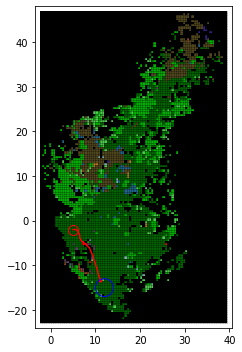

Trial took 2.5058000087738037s
thres=0.0 (1/5), trial (1/10)
goal reached after 80 steps


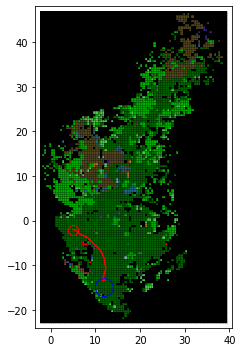

Trial took 2.8665518760681152s
thres=0.2 (2/5), trial (1/10)
goal reached after 80 steps


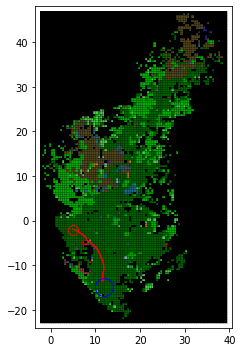

Trial took 2.7911605834960938s
thres=0.4 (3/5), trial (1/10)
goal reached after 76 steps


Trial took 2.6366963386535645s
thres=0.6 (4/5), trial (1/10)
goal reached after 77 steps


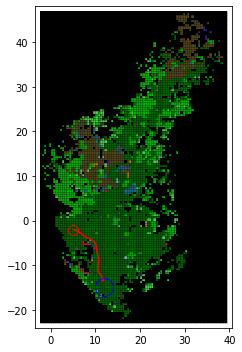

Trial took 2.6290578842163086s
thres=0.8 (5/5), trial (1/10)
goal reached after 73 steps


Trial took 2.5091910362243652s
using gt, trial (2/10)
goal reached after 72 steps


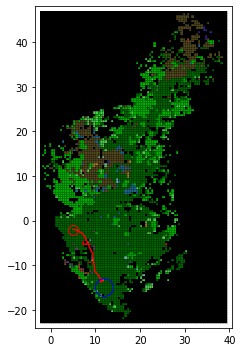

Trial took 2.4718048572540283s
thres=0.0 (1/5), trial (2/10)
goal reached after 76 steps


Trial took 2.789485454559326s
thres=0.2 (2/5), trial (2/10)


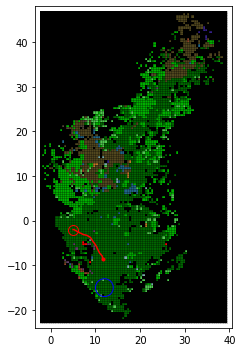

Trial took 10.090155839920044s
thres=0.4 (3/5), trial (2/10)
goal reached after 71 steps


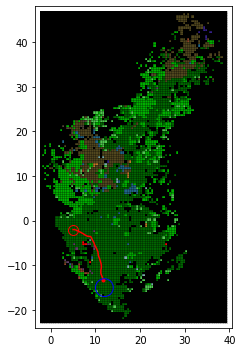

Trial took 2.4689159393310547s
thres=0.6 (4/5), trial (2/10)


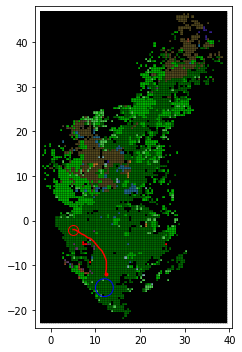

Trial took 7.616877794265747s
thres=0.8 (5/5), trial (2/10)


Trial took 7.2145490646362305s
using gt, trial (3/10)
goal reached after 73 steps


Trial took 2.6678574085235596s
thres=0.0 (1/5), trial (3/10)
goal reached after 72 steps


Trial took 2.527956485748291s
thres=0.2 (2/5), trial (3/10)
goal reached after 73 steps


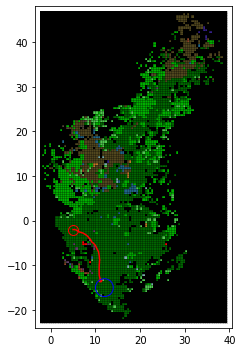

Trial took 2.5492894649505615s
thres=0.4 (3/5), trial (3/10)
goal reached after 79 steps


Trial took 2.743774890899658s
thres=0.6 (4/5), trial (3/10)
goal reached after 84 steps


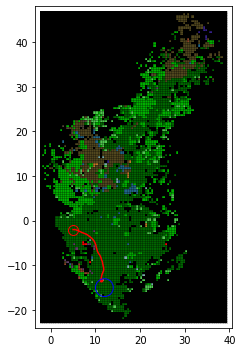

Trial took 2.896568536758423s
thres=0.8 (5/5), trial (3/10)
goal reached after 80 steps


Trial took 2.990407705307007s
using gt, trial (4/10)
goal reached after 66 steps


Trial took 2.295076847076416s
thres=0.0 (1/5), trial (4/10)
goal reached after 76 steps


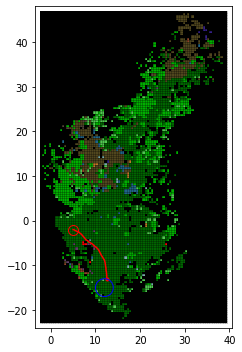

Trial took 2.658947229385376s
thres=0.2 (2/5), trial (4/10)
goal reached after 70 steps


Trial took 2.4005796909332275s
thres=0.4 (3/5), trial (4/10)
goal reached after 82 steps


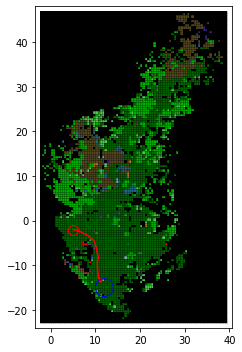

Trial took 2.817657470703125s
thres=0.6 (4/5), trial (4/10)
goal reached after 82 steps


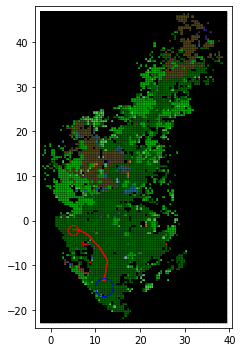

Trial took 2.9761831760406494s
thres=0.8 (5/5), trial (4/10)
goal reached after 84 steps


Trial took 2.8501853942871094s
using gt, trial (5/10)
goal reached after 68 steps


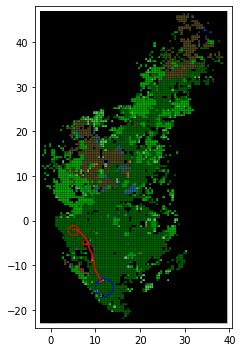

Trial took 2.370765447616577s
thres=0.0 (1/5), trial (5/10)
goal reached after 80 steps


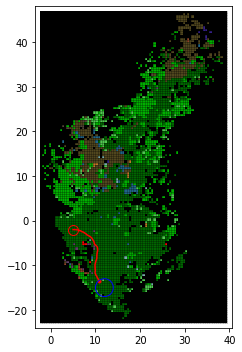

Trial took 2.796792507171631s
thres=0.2 (2/5), trial (5/10)
goal reached after 92 steps


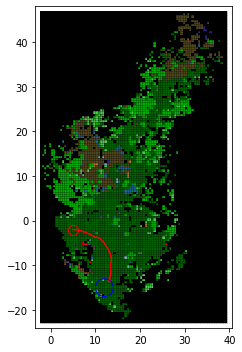

Trial took 3.156749725341797s
thres=0.4 (3/5), trial (5/10)
goal reached after 81 steps


Trial took 2.976546049118042s
thres=0.6 (4/5), trial (5/10)
goal reached after 87 steps


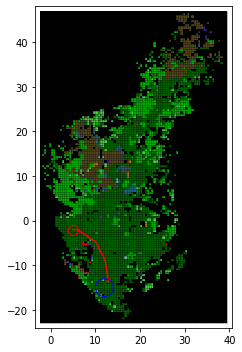

Trial took 3.0186703205108643s
thres=0.8 (5/5), trial (5/10)
goal reached after 81 steps


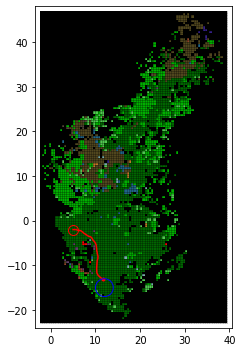

Trial took 2.8059048652648926s
using gt, trial (6/10)
goal reached after 69 steps


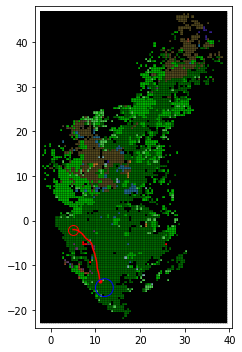

Trial took 2.353912115097046s
thres=0.0 (1/5), trial (6/10)
goal reached after 73 steps


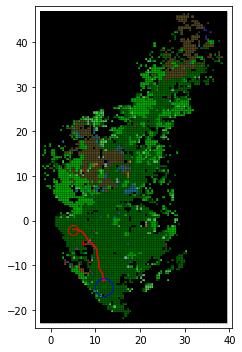

Trial took 2.5791847705841064s
thres=0.2 (2/5), trial (6/10)
goal reached after 72 steps


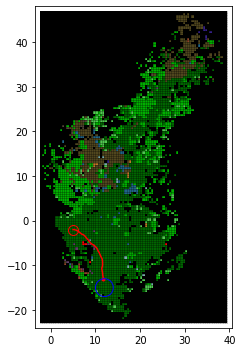

Trial took 2.6705005168914795s
thres=0.4 (3/5), trial (6/10)
goal reached after 76 steps


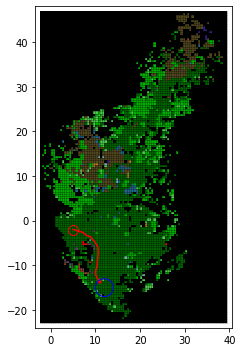

Trial took 2.6333110332489014s
thres=0.6 (4/5), trial (6/10)
goal reached after 84 steps


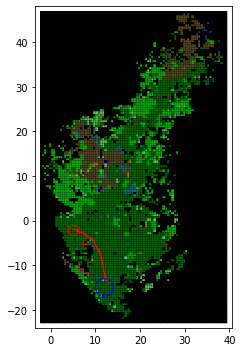

Trial took 2.865772247314453s
thres=0.8 (5/5), trial (6/10)
goal reached after 79 steps


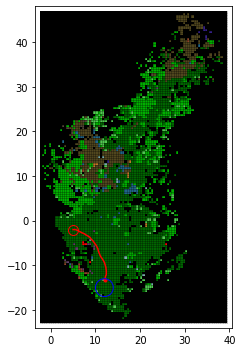

Trial took 2.7113358974456787s
using gt, trial (7/10)
goal reached after 68 steps


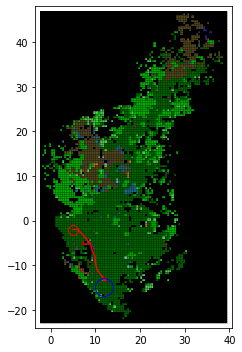

Trial took 2.3526394367218018s
thres=0.0 (1/5), trial (7/10)
goal reached after 72 steps


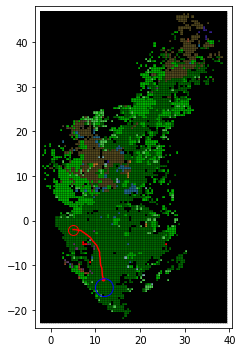

Trial took 2.676481008529663s
thres=0.2 (2/5), trial (7/10)
goal reached after 73 steps


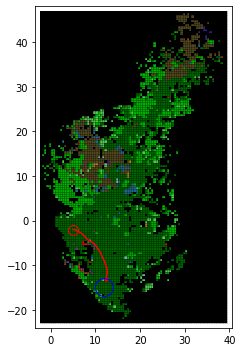

Trial took 2.519374370574951s
thres=0.4 (3/5), trial (7/10)


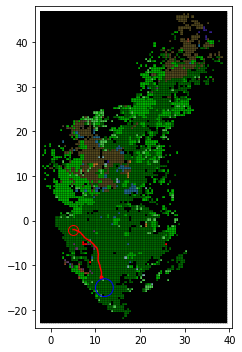

Trial took 6.8767249584198s
thres=0.6 (4/5), trial (7/10)
goal reached after 74 steps


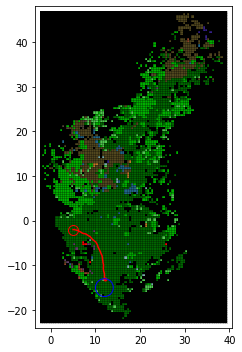

Trial took 2.5915212631225586s
thres=0.8 (5/5), trial (7/10)
goal reached after 84 steps


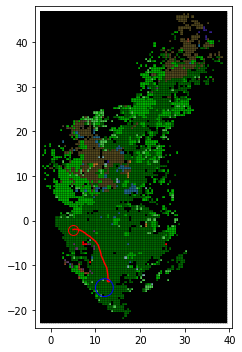

Trial took 2.909986972808838s
using gt, trial (8/10)


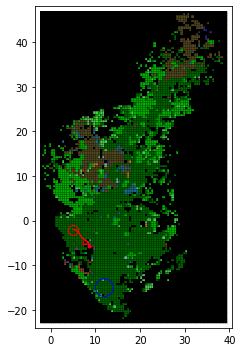

Trial took 10.503488063812256s
thres=0.0 (1/5), trial (8/10)


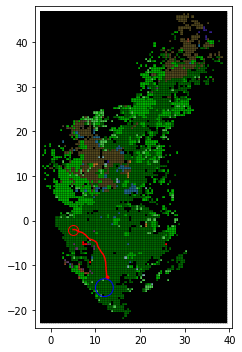

Trial took 6.60780668258667s
thres=0.2 (2/5), trial (8/10)
goal reached after 71 steps


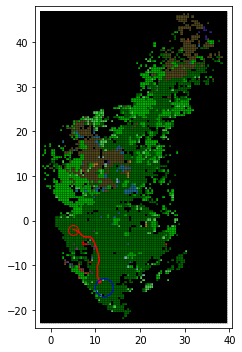

Trial took 2.5159292221069336s
thres=0.4 (3/5), trial (8/10)
goal reached after 74 steps


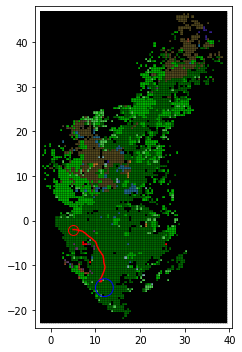

Trial took 2.5329015254974365s
thres=0.6 (4/5), trial (8/10)
goal reached after 68 steps


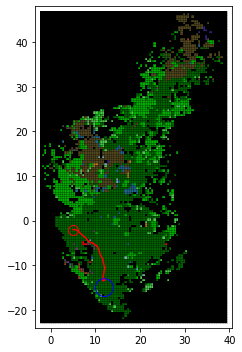

Trial took 2.3998894691467285s
thres=0.8 (5/5), trial (8/10)
goal reached after 75 steps


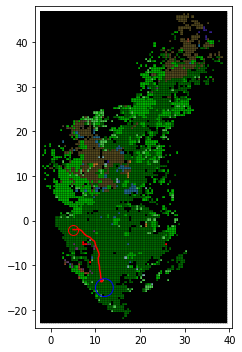

Trial took 2.8796870708465576s
using gt, trial (9/10)
goal reached after 69 steps


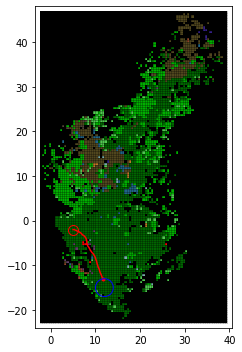

Trial took 2.4675471782684326s
thres=0.0 (1/5), trial (9/10)
goal reached after 72 steps


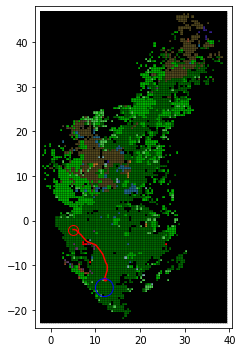

Trial took 2.556816816329956s
thres=0.2 (2/5), trial (9/10)
goal reached after 73 steps


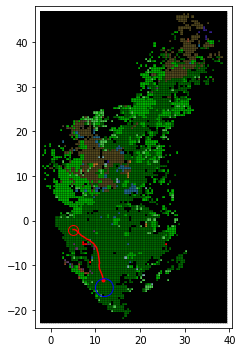

Trial took 2.5569064617156982s
thres=0.4 (3/5), trial (9/10)
goal reached after 68 steps


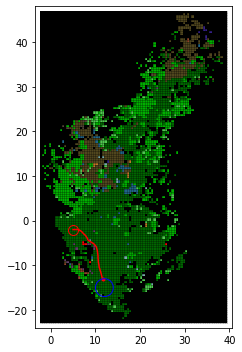

Trial took 2.479351282119751s
thres=0.6 (4/5), trial (9/10)
goal reached after 78 steps


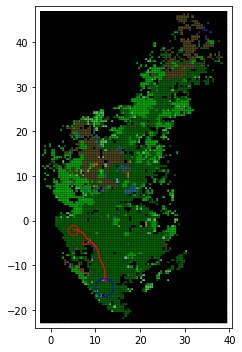

Trial took 2.949366807937622s
thres=0.8 (5/5), trial (9/10)
goal reached after 72 steps


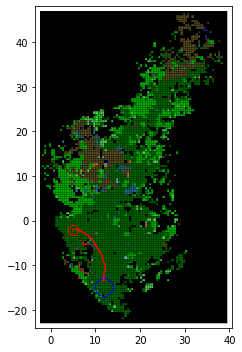

Trial took 2.584967613220215s
using gt, trial (10/10)
goal reached after 64 steps


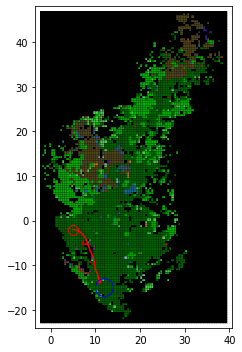

Trial took 2.2795755863189697s
thres=0.0 (1/5), trial (10/10)
goal reached after 73 steps


Trial took 2.625032424926758s
thres=0.2 (2/5), trial (10/10)
goal reached after 75 steps


Trial took 2.5538501739501953s
thres=0.4 (3/5), trial (10/10)
goal reached after 71 steps


Trial took 2.778445243835449s
thres=0.6 (4/5), trial (10/10)
goal reached after 79 steps


Trial took 2.7286643981933594s
thres=0.8 (5/5), trial (10/10)
goal reached after 82 steps


Trial took 2.907271146774292s
using gt, trial (1/10)
goal reached after 124 steps


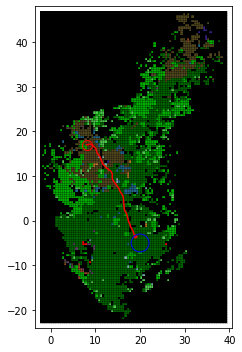

Trial took 4.418856859207153s
thres=0.0 (1/5), trial (1/10)
goal reached after 132 steps


Trial took 4.705307960510254s
thres=0.2 (2/5), trial (1/10)


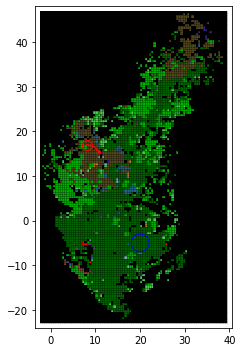

Trial took 10.866077184677124s
thres=0.4 (3/5), trial (1/10)
goal reached after 131 steps


Trial took 4.624013423919678s
thres=0.6 (4/5), trial (1/10)
goal reached after 138 steps


Trial took 4.848878383636475s
thres=0.8 (5/5), trial (1/10)
goal reached after 160 steps


Trial took 5.581293106079102s
using gt, trial (2/10)
goal reached after 135 steps


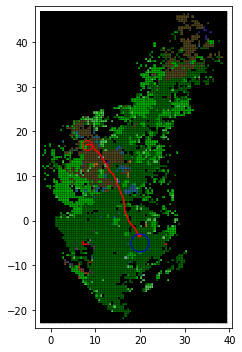

Trial took 4.746940851211548s
thres=0.0 (1/5), trial (2/10)
goal reached after 137 steps


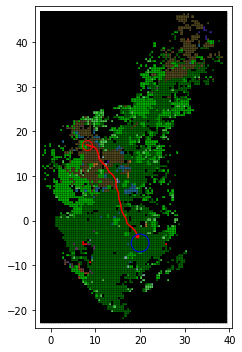

Trial took 4.9417619705200195s
thres=0.2 (2/5), trial (2/10)
goal reached after 136 steps


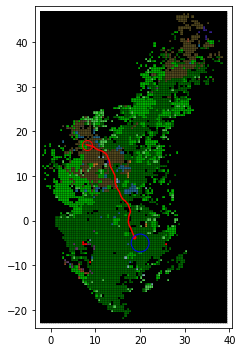

Trial took 4.792333126068115s
thres=0.4 (3/5), trial (2/10)
goal reached after 141 steps


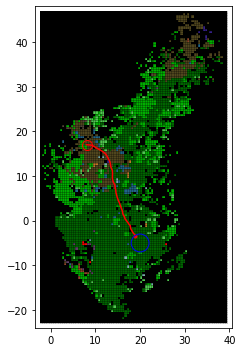

Trial took 4.996223211288452s
thres=0.6 (4/5), trial (2/10)
goal reached after 142 steps


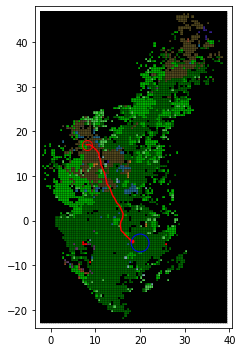

Trial took 4.924036979675293s
thres=0.8 (5/5), trial (2/10)
goal reached after 151 steps


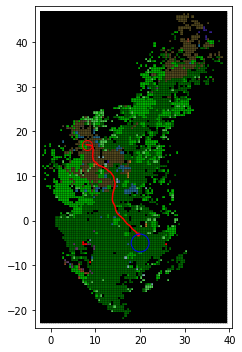

Trial took 5.250730752944946s
using gt, trial (3/10)
goal reached after 129 steps


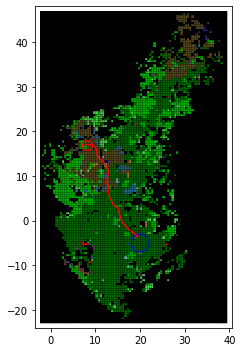

Trial took 4.7570273876190186s
thres=0.0 (1/5), trial (3/10)


Trial took 10.472528219223022s
thres=0.2 (2/5), trial (3/10)


Trial took 10.697664022445679s
thres=0.4 (3/5), trial (3/10)


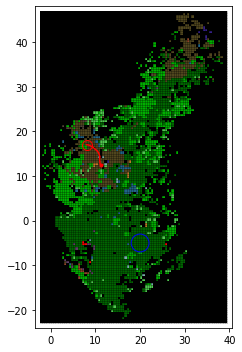

Trial took 10.658315896987915s
thres=0.6 (4/5), trial (3/10)


Trial took 10.498535633087158s
thres=0.8 (5/5), trial (3/10)
goal reached after 161 steps


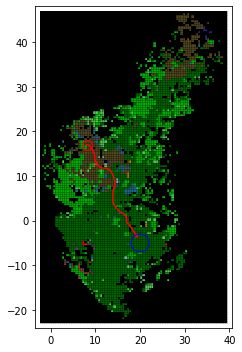

Trial took 5.7744300365448s
using gt, trial (4/10)
goal reached after 129 steps


Trial took 4.55410099029541s
thres=0.0 (1/5), trial (4/10)
goal reached after 139 steps


Trial took 4.860000371932983s
thres=0.2 (2/5), trial (4/10)
goal reached after 144 steps


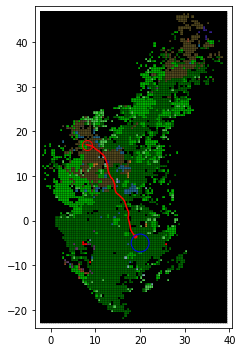

Trial took 5.031393051147461s
thres=0.4 (3/5), trial (4/10)
goal reached after 137 steps


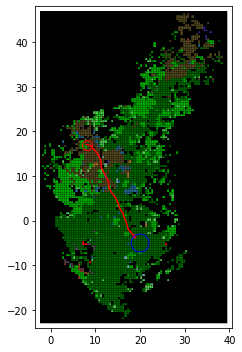

Trial took 4.809669256210327s
thres=0.6 (4/5), trial (4/10)
goal reached after 132 steps


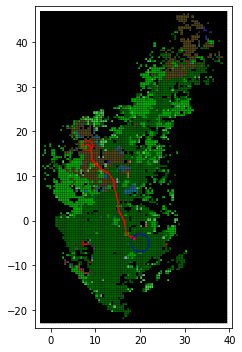

Trial took 4.88911771774292s
thres=0.8 (5/5), trial (4/10)


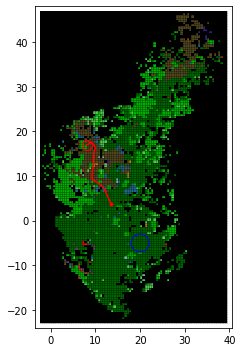

Trial took 10.42268681526184s
using gt, trial (5/10)
goal reached after 126 steps


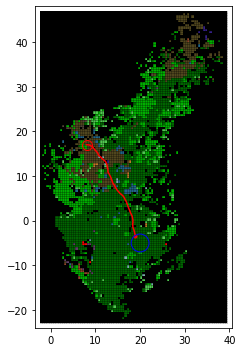

Trial took 4.472566843032837s
thres=0.0 (1/5), trial (5/10)
goal reached after 134 steps


Trial took 4.677777528762817s
thres=0.2 (2/5), trial (5/10)
goal reached after 138 steps


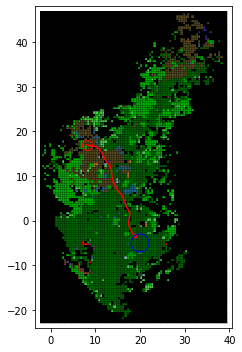

Trial took 4.851262807846069s
thres=0.4 (3/5), trial (5/10)
goal reached after 133 steps


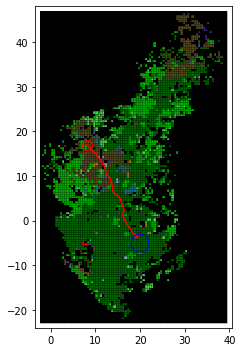

Trial took 4.840422630310059s
thres=0.6 (4/5), trial (5/10)
goal reached after 151 steps


Trial took 5.211075782775879s
thres=0.8 (5/5), trial (5/10)
goal reached after 157 steps


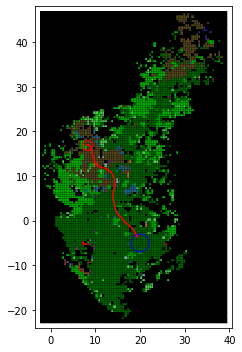

Trial took 5.413860082626343s
using gt, trial (6/10)


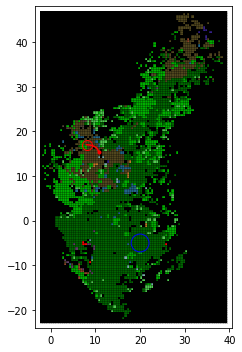

Trial took 10.697235107421875s
thres=0.0 (1/5), trial (6/10)


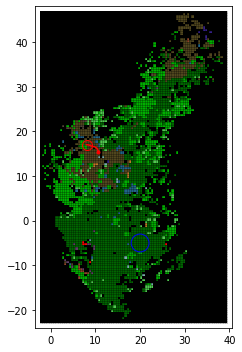

Trial took 10.681202411651611s
thres=0.2 (2/5), trial (6/10)
goal reached after 136 steps


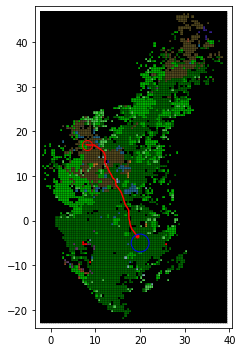

Trial took 4.9551122188568115s
thres=0.4 (3/5), trial (6/10)


Trial took 10.576290607452393s
thres=0.6 (4/5), trial (6/10)


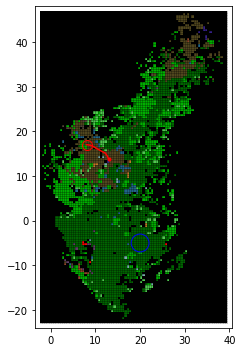

Trial took 10.603427410125732s
thres=0.8 (5/5), trial (6/10)
goal reached after 156 steps


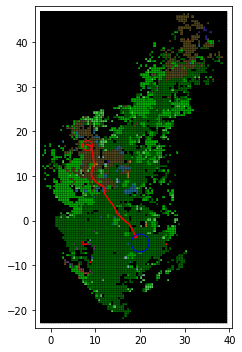

Trial took 5.407371282577515s
using gt, trial (7/10)
goal reached after 125 steps


Trial took 4.3019843101501465s
thres=0.0 (1/5), trial (7/10)
goal reached after 128 steps


Trial took 4.550413608551025s
thres=0.2 (2/5), trial (7/10)
goal reached after 131 steps


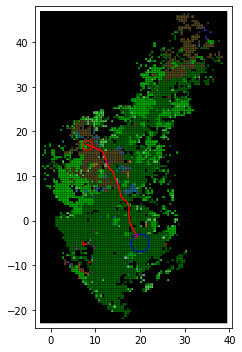

Trial took 4.583462476730347s
thres=0.4 (3/5), trial (7/10)
goal reached after 143 steps


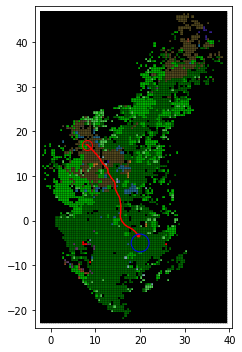

Trial took 4.958604335784912s
thres=0.6 (4/5), trial (7/10)
goal reached after 152 steps


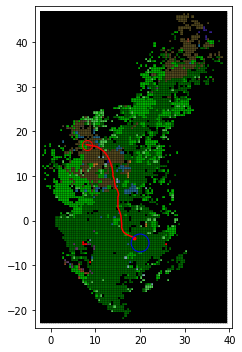

Trial took 5.309682846069336s
thres=0.8 (5/5), trial (7/10)


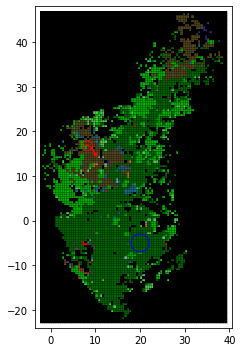

Trial took 10.436050176620483s
using gt, trial (8/10)
goal reached after 120 steps


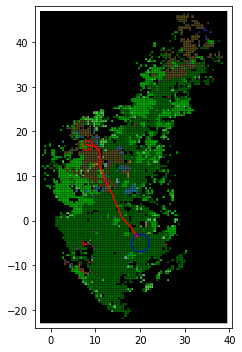

Trial took 4.415662050247192s
thres=0.0 (1/5), trial (8/10)
goal reached after 130 steps


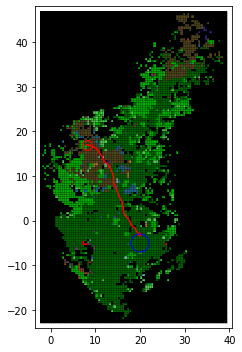

Trial took 4.583510160446167s
thres=0.2 (2/5), trial (8/10)
goal reached after 127 steps


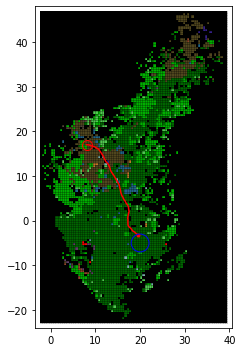

Trial took 4.40787148475647s
thres=0.4 (3/5), trial (8/10)
goal reached after 135 steps


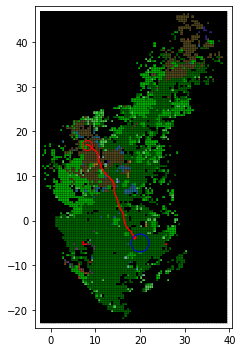

Trial took 4.750625371932983s
thres=0.6 (4/5), trial (8/10)
goal reached after 146 steps


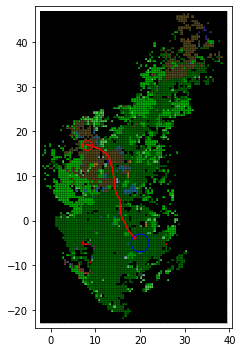

Trial took 5.057340860366821s
thres=0.8 (5/5), trial (8/10)
goal reached after 170 steps


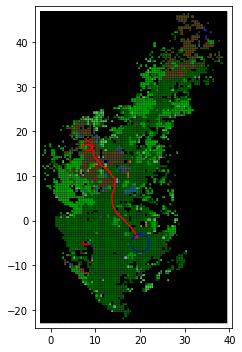

Trial took 6.10913610458374s
using gt, trial (9/10)
goal reached after 126 steps


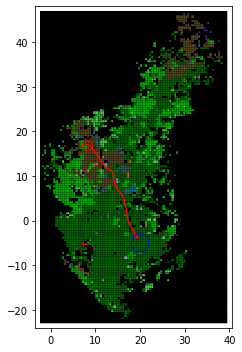

Trial took 4.440981388092041s
thres=0.0 (1/5), trial (9/10)
goal reached after 152 steps


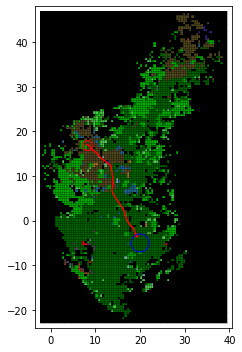

Trial took 5.275768518447876s
thres=0.2 (2/5), trial (9/10)
goal reached after 128 steps


Trial took 4.497701168060303s
thres=0.4 (3/5), trial (9/10)
goal reached after 137 steps


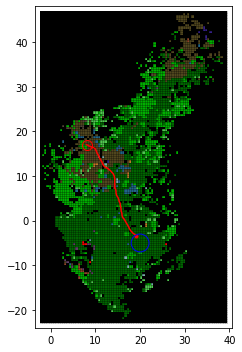

Trial took 4.815149545669556s
thres=0.6 (4/5), trial (9/10)
goal reached after 147 steps


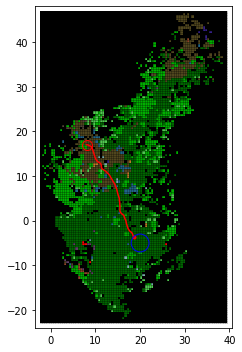

Trial took 5.256605386734009s
thres=0.8 (5/5), trial (9/10)
goal reached after 150 steps


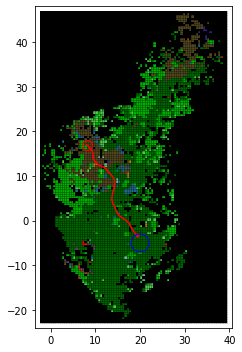

Trial took 5.154829978942871s
using gt, trial (10/10)
goal reached after 132 steps


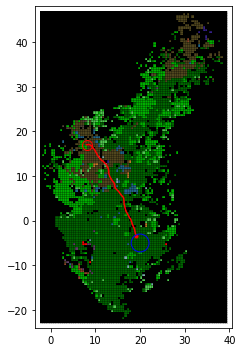

Trial took 4.827036142349243s
thres=0.0 (1/5), trial (10/10)


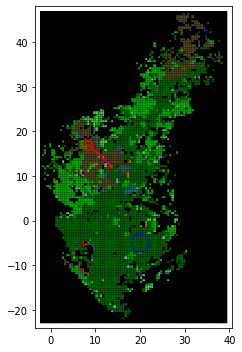

Trial took 10.940815448760986s
thres=0.2 (2/5), trial (10/10)


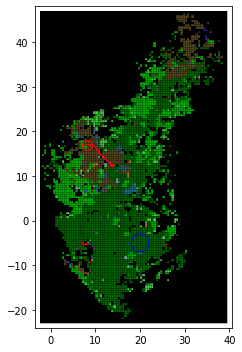

Trial took 10.73961853981018s
thres=0.4 (3/5), trial (10/10)


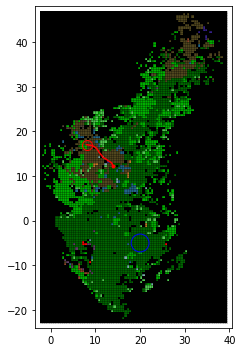

Trial took 11.066313028335571s
thres=0.6 (4/5), trial (10/10)
goal reached after 152 steps


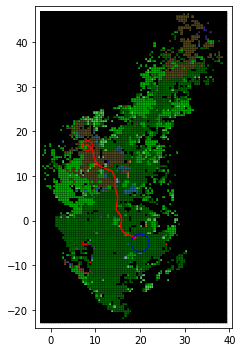

Trial took 5.16434121131897s
thres=0.8 (5/5), trial (10/10)
goal reached after 142 steps


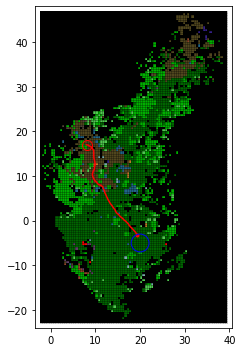

Trial took 4.923926591873169s
using gt, trial (1/10)
goal reached after 206 steps


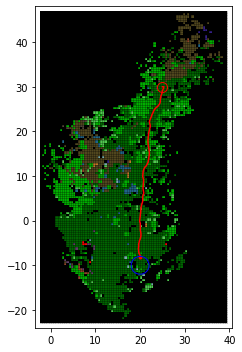

Trial took 7.131098508834839s
thres=0.0 (1/5), trial (1/10)
goal reached after 239 steps


Trial took 8.201129674911499s
thres=0.2 (2/5), trial (1/10)
goal reached after 242 steps


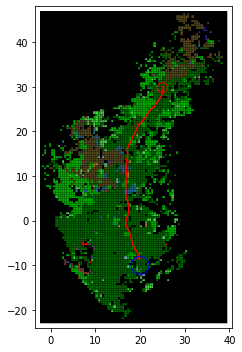

Trial took 8.520735502243042s
thres=0.4 (3/5), trial (1/10)
goal reached after 247 steps


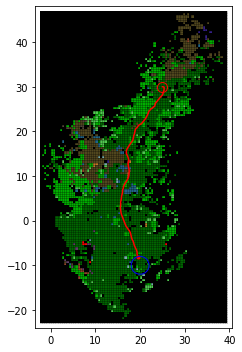

Trial took 8.527750015258789s
thres=0.6 (4/5), trial (1/10)
goal reached after 266 steps


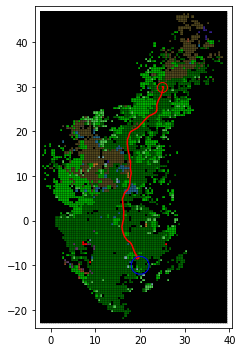

Trial took 9.101468563079834s
thres=0.8 (5/5), trial (1/10)


Trial took 10.279195785522461s
using gt, trial (2/10)
goal reached after 233 steps


Trial took 8.124850749969482s
thres=0.0 (1/5), trial (2/10)
goal reached after 236 steps


Trial took 8.445122003555298s
thres=0.2 (2/5), trial (2/10)
goal reached after 238 steps


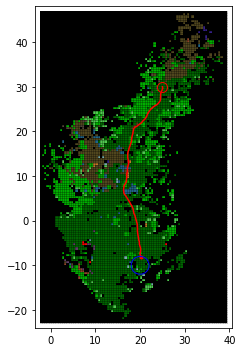

Trial took 8.303414106369019s
thres=0.4 (3/5), trial (2/10)
goal reached after 241 steps


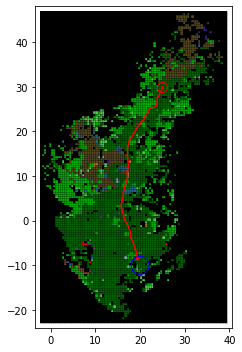

Trial took 8.388035297393799s
thres=0.6 (4/5), trial (2/10)
goal reached after 242 steps


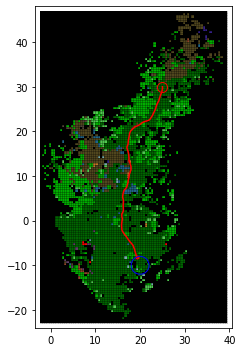

Trial took 8.304025650024414s
thres=0.8 (5/5), trial (2/10)


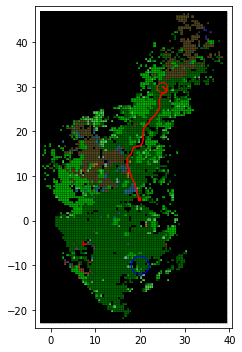

Trial took 10.38687777519226s
using gt, trial (3/10)


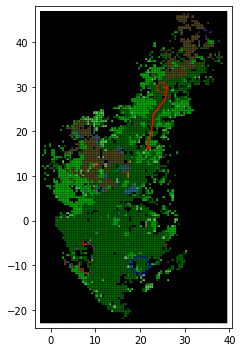

Trial took 10.705403089523315s
thres=0.0 (1/5), trial (3/10)


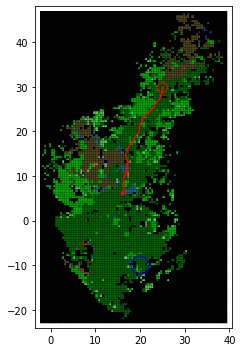

Trial took 10.486863374710083s
thres=0.2 (2/5), trial (3/10)
goal reached after 233 steps


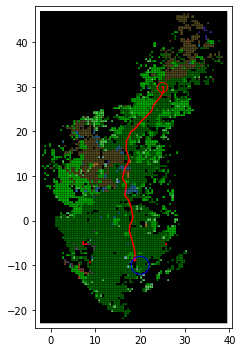

Trial took 7.958691358566284s
thres=0.4 (3/5), trial (3/10)


Trial took 10.443703174591064s
thres=0.6 (4/5), trial (3/10)


Trial took 10.404387712478638s
thres=0.8 (5/5), trial (3/10)


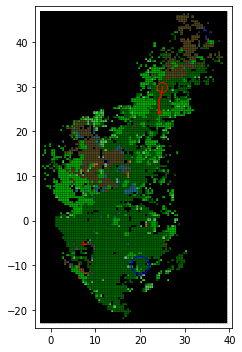

Trial took 10.342949628829956s
using gt, trial (4/10)


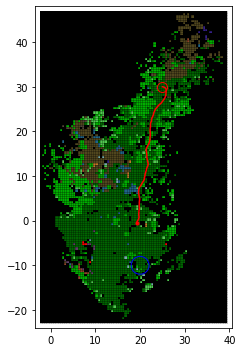

Trial took 10.488879442214966s
thres=0.0 (1/5), trial (4/10)


Trial took 10.441019773483276s
thres=0.2 (2/5), trial (4/10)
goal reached after 248 steps


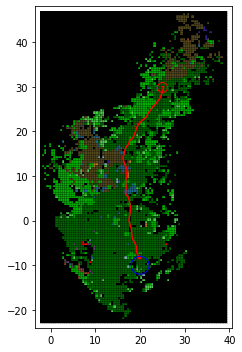

Trial took 8.594456672668457s
thres=0.4 (3/5), trial (4/10)
goal reached after 282 steps


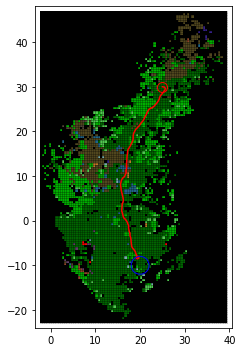

Trial took 9.628082036972046s
thres=0.6 (4/5), trial (4/10)
goal reached after 256 steps


Trial took 8.97370982170105s
thres=0.8 (5/5), trial (4/10)


Trial took 10.172745704650879s
using gt, trial (5/10)
goal reached after 221 steps


Trial took 7.63207745552063s
thres=0.0 (1/5), trial (5/10)
goal reached after 239 steps


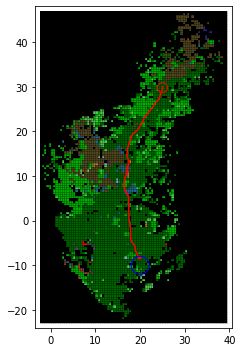

Trial took 8.18728232383728s
thres=0.2 (2/5), trial (5/10)
goal reached after 224 steps


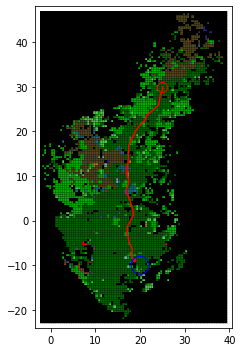

Trial took 7.678771257400513s
thres=0.4 (3/5), trial (5/10)
goal reached after 246 steps


Trial took 8.615007638931274s
thres=0.6 (4/5), trial (5/10)
goal reached after 254 steps


Trial took 8.70055627822876s
thres=0.8 (5/5), trial (5/10)


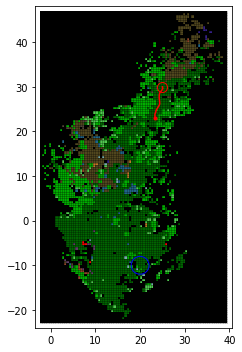

Trial took 10.200145959854126s
using gt, trial (6/10)
goal reached after 229 steps


Trial took 7.9225852489471436s
thres=0.0 (1/5), trial (6/10)
goal reached after 235 steps


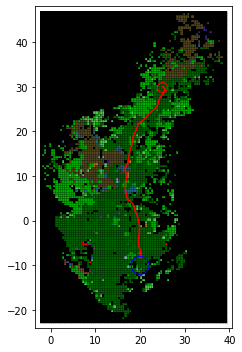

Trial took 8.142504692077637s
thres=0.2 (2/5), trial (6/10)


Trial took 10.684056997299194s
thres=0.4 (3/5), trial (6/10)


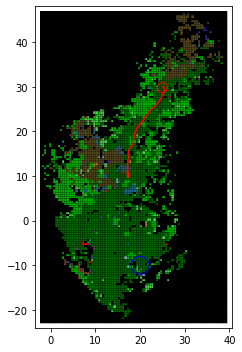

Trial took 10.463901996612549s
thres=0.6 (4/5), trial (6/10)


Trial took 10.417068243026733s
thres=0.8 (5/5), trial (6/10)


Trial took 10.18211841583252s
using gt, trial (7/10)
goal reached after 226 steps


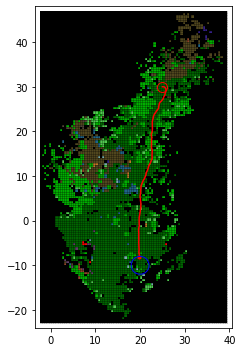

Trial took 7.8073341846466064s
thres=0.0 (1/5), trial (7/10)


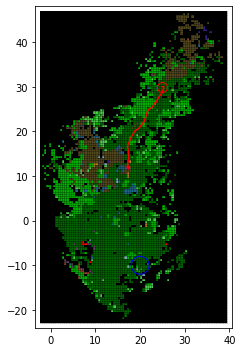

Trial took 10.59840178489685s
thres=0.2 (2/5), trial (7/10)


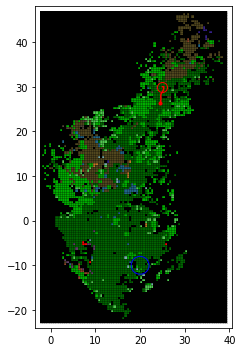

Trial took 10.331011295318604s
thres=0.4 (3/5), trial (7/10)
goal reached after 235 steps


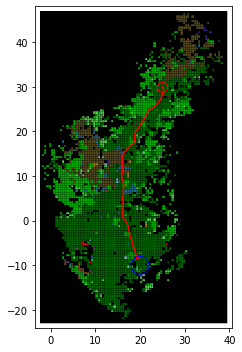

Trial took 8.137479782104492s
thres=0.6 (4/5), trial (7/10)
goal reached after 249 steps


Trial took 8.59238338470459s
thres=0.8 (5/5), trial (7/10)


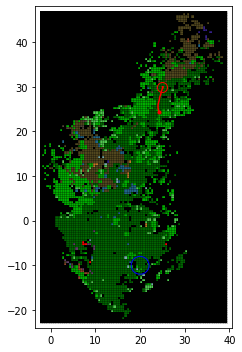

Trial took 10.164138317108154s
using gt, trial (8/10)


Trial took 10.714773178100586s
thres=0.0 (1/5), trial (8/10)
goal reached after 241 steps


Trial took 8.271265268325806s
thres=0.2 (2/5), trial (8/10)
goal reached after 252 steps


Trial took 8.671162843704224s
thres=0.4 (3/5), trial (8/10)
goal reached after 226 steps


Trial took 7.889032602310181s
thres=0.6 (4/5), trial (8/10)
goal reached after 254 steps


Trial took 8.819833993911743s
thres=0.8 (5/5), trial (8/10)


Trial took 10.411904573440552s
using gt, trial (9/10)
goal reached after 205 steps


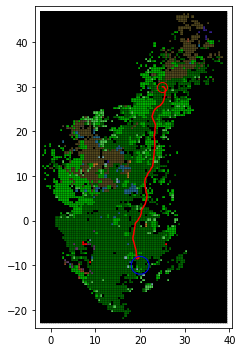

Trial took 7.098156690597534s
thres=0.0 (1/5), trial (9/10)
goal reached after 232 steps


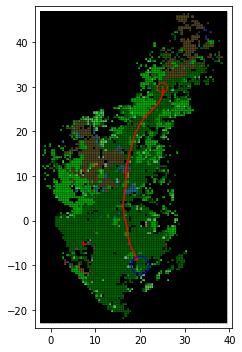

Trial took 7.990344524383545s
thres=0.2 (2/5), trial (9/10)
goal reached after 258 steps


Trial took 8.858868598937988s
thres=0.4 (3/5), trial (9/10)
goal reached after 240 steps


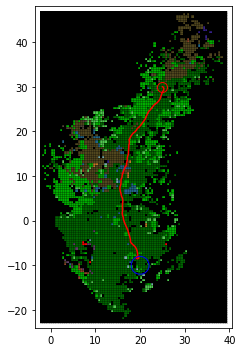

Trial took 8.292837619781494s
thres=0.6 (4/5), trial (9/10)


Trial took 10.680352449417114s
thres=0.8 (5/5), trial (9/10)


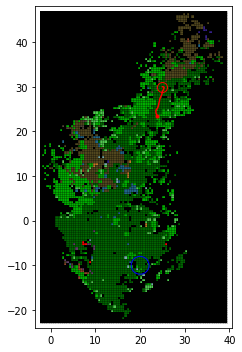

Trial took 10.182507514953613s
using gt, trial (10/10)
goal reached after 215 steps


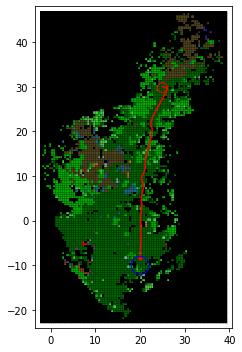

Trial took 7.4956090450286865s
thres=0.0 (1/5), trial (10/10)
goal reached after 243 steps


Trial took 8.336734771728516s
thres=0.2 (2/5), trial (10/10)
goal reached after 225 steps


Trial took 7.755845785140991s
thres=0.4 (3/5), trial (10/10)
goal reached after 251 steps


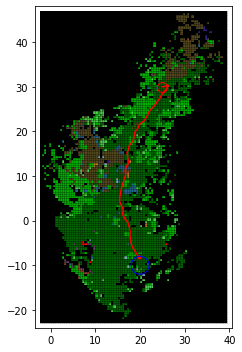

Trial took 8.74677300453186s
thres=0.6 (4/5), trial (10/10)
goal reached after 281 steps


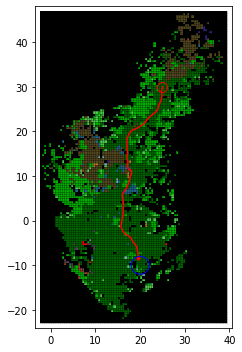

Trial took 9.58988070487976s
thres=0.8 (5/5), trial (10/10)


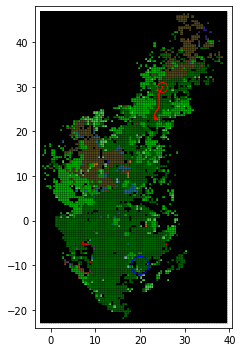

Trial took 10.229713916778564s


In [32]:
# Trial function
def trial(mppi_planner, pred_lin_tdm, traction_grid, dt, max_steps, mppi_params):
  # Loop
  xhist = np.zeros((max_steps+1, 3))*np.nan
  uhist = np.zeros((max_steps, 2))*np.nan
  xhist[0] = mppi_params['x0']
  goal_reached = False
  dist_to_goal = np.nan
  cum_obj = 0
  cum_dist_to_goal = 0
  for t in range(max_steps):
    # Solve
    useq = mppi_planner.solve()
    u_curr = useq[0]
    uhist[t] = u_curr

    # Simulate state forward using the sampled map
    lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
    xhist[t+1, 0] = xhist[t, 0] + dt*lt*np.cos(xhist[t, 2])*u_curr[0]
    xhist[t+1, 1] = xhist[t, 1] + dt*lt*np.sin(xhist[t, 2])*u_curr[0]
    xhist[t+1, 2] = xhist[t, 2] + dt*at*u_curr[1]
    
    # Update MPPI state (x0, useq)
    mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

    # Accumulate stage cost
    dist_to_goal = np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) - mppi_params['goal_tolerance']
    cum_obj += (dt+dist_to_goal)
    cum_dist_to_goal += dist_to_goal

    # Goal check
    if dist_to_goal <= 0:
      goal_reached = True
      break
  
  # Also log the dist to goal (minus the tolerance)
  if goal_reached:
    dist_to_goal = np.nan
    print("goal reached after {} steps".format(t+1))
  else:
    cum_obj += (1-goal_reached)*dist_to_goal/mppi_params['v_post_rollout']

  lin_tdm_vis = TDM_Visualizer(pred_lin_tdm, tdm_contains_semantic_grid=False)
  fig, ax = lin_tdm_vis.draw(figsize=(5, 5), semantic_grid=semantic_grid, id2rgb_map=id2rgb_map)
  ax.plot([mppi_params['x0'][0]], [mppi_params['x0'][1]], 'ro', markersize=10, markerfacecolor='none', label="Start")
  ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ro', markersize=3, label="Curr. State", zorder=5)
  c1 = plt.Circle(mppi_params['xgoal'], mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
  ax.add_patch(c1)
  plt.axis("on")
  ax.plot(xhist[:,0], xhist[:,1], 'r', label="Past State")
  plt.tight_layout()
  plt.show()

  # Return trial_info
  trial_logger = dict(
    time_to_goal=(t+1)*dt if goal_reached else np.nan,
    success=goal_reached,
    dist_to_goal=dist_to_goal,
    cum_dist_to_goal=cum_dist_to_goal,
    avg_dist_to_goal=cum_dist_to_goal/(t+1),
    cum_obj=cum_obj,
    # xhist=xhist,
    # uhist=uhist
  )
  return trial_logger



"""
Use the same TDM algorithm but we adjust the confidence tolerance and adjust he PMF used for sampling
"""



def all_trials(start_goal_pairs, mppi_planner, pred_lin_tdm, pred_ang_tdm, pred_tdm_info,
  gt_lin_tdm, gt_ang_tdm, max_steps, num_trials, confidence_thres_list, default_mppi_params):

  loggers = []
  # Firstly, sample traction from the GROUNDTRUTH!
  # Pregenerate num_trials of traction map
  traction_grid_list = [sample_traction_grid(gt_lin_tdm, gt_ang_tdm) for i in range(num_trials)] 


  # Loop trials
  for start_goal_i, (x0, xgoal) in enumerate(start_goal_pairs):
    mppi_params = copy.deepcopy(default_mppi_params)
    mppi_params['x0'] = x0
    mppi_params['xgoal'] = xgoal

    for trial_i, traction_grid in enumerate(traction_grid_list):

      # Run trials for gt dynamics
      print("using gt, trial ({}/{})".format(
        trial_i+1, num_trials
      ))
      t0 = time.time()
      # Construct the MPPI planner + initialize the GPU variables
      gt_lin_tdm.reset()
      gt_ang_tdm.reset()
      mppi_planner.reset()

      reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'])
      mppi_planner.setup(mppi_params, gt_lin_tdm, gt_ang_tdm)
      trial_log = trial(mppi_planner, gt_lin_tdm, traction_grid, cfg.dt, max_steps, mppi_params)
      
      trial_log['confidence_thres'] = np.nan
      trial_log['use_gt'] = True
      trial_log['start_goal_i'] = start_goal_i
      trial_log['x0'] = x0
      trial_log['xgoal'] = xgoal
      loggers.append(trial_log)
      print("Trial took {}s".format(time.time()-t0))


      # Run trials for predicted dyanmics with different resholds
      for thres_i, thres in enumerate(confidence_thres_list):
        modified_pred_tdm_info = copy.deepcopy(pred_tdm_info)
        # For places where we don't have access to ground truth, also mask away the same region in the predicted map.
        gt_unknown = gt_tdm_info["unknown_colors_mask"]
        modified_pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
        modified_pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
        # Adjust the PMF
        modified_pred_tdm_info["lin_pmf_grid"][0,gt_unknown] = 100
        modified_pred_tdm_info["lin_pmf_grid"][1:,gt_unknown] = 0
        modified_pred_tdm_info["ang_pmf_grid"][0,gt_unknown] = 100
        modified_pred_tdm_info["ang_pmf_grid"][1:,gt_unknown] = 0
        # For places where ground truth is 0 traction, we mask away the predicted map as well
        gt_no_traction_mask = gt_tdm_info["lin_pmf_grid"][0,:,:]==100
        modified_pred_tdm_info["lin_pmf_grid"][0,gt_no_traction_mask]=100
        modified_pred_tdm_info["lin_pmf_grid"][1:,gt_no_traction_mask]=0
        modified_pred_tdm_info["ang_pmf_grid"][0,gt_no_traction_mask]=100
        modified_pred_tdm_info["ang_pmf_grid"][1:,gt_no_traction_mask]=0

        # Mask away the tractions where confidence score is very low
        low_conf_mask = modified_pred_tdm_info["normalized_confidence"] < thres
        modified_pred_tdm_info["lin_pmf_grid"][0,low_conf_mask]=100
        modified_pred_tdm_info["lin_pmf_grid"][1:,low_conf_mask]=0
        modified_pred_tdm_info["ang_pmf_grid"][0,low_conf_mask]=100
        modified_pred_tdm_info["ang_pmf_grid"][1:,low_conf_mask]=0

      
        print("thres={} ({}/{}), trial ({}/{})".format(
          thres, thres_i+1, len(confidence_thres_list),
          trial_i+1, num_trials
        ))
        t0 = time.time()
        # Construct the MPPI planner + initialize the GPU variables
        pred_lin_tdm.reset()
        pred_ang_tdm.reset()
        mppi_planner.reset()

        reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, modified_pred_tdm_info, mppi_params['alpha_dyn'])
        mppi_planner.setup(mppi_params, pred_lin_tdm, pred_ang_tdm)
        trial_log = trial(mppi_planner, pred_lin_tdm, traction_grid, cfg.dt, max_steps, mppi_params)
        
        trial_log['confidence_thres'] = thres
        trial_log['use_gt'] = False
        trial_log['start_goal_i'] = start_goal_i
        trial_log['x0'] = x0
        trial_log['xgoal'] = xgoal
        loggers.append(trial_log)
        print("Trial took {}s".format(time.time()-t0))

  return pd.DataFrame(loggers)






max_speed = 3
max_angular = np.pi
use_tdm = True# True # True
use_det_dynamics = False # True
use_nom_dynamics_with_speed_map = False # 
use_costmap = False

# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024, # 5*1024, #1024,
  num_control_rollouts = 1024,
  max_speed_padding = max_speed+2.0,
  num_vis_state_rollouts = 20,
  max_map_dim =(150, 150),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)


gt_lin_tdm = TDM_Numba(cfg)
gt_ang_tdm = TDM_Numba(cfg)
pred_lin_tdm = TDM_Numba(cfg)
pred_ang_tdm = TDM_Numba(cfg)
mppi_planner = MPPI_Numba(cfg)


# ------------- Problem configuration ------------
start_goal_pairs = [
  (np.array([5, -2, 0]), np.array([12, -15])),
  (np.array([8, 17, 0]), np.array([20, -5])),
  (np.array([25, 30, 0]), np.array([20, -10])),
]


goal_tolerance = 2.0
mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=None,
    xgoal=None,

    # For risk-aware min time planning
    goal_tolerance=goal_tolerance,
    v_post_rollout=0.01,
    cvar_alpha=1.0, # use the mean of objectives if cvar_alpha=1.0
    alpha_dyn=1.0, # sample tractions from worst alpha_dyn-percentile  (mostly for TDM)

    dist_weight=1.0,

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 2.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0.0, max_speed]), 
    wrange=np.array([-max_angular, max_angular]),
)



max_steps = 300
num_trials = 10
confidence_thres_list = [0.0, 0.2, 0.4, 0.6, 0.8]
reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'])
df = all_trials(start_goal_pairs, mppi_planner, pred_lin_tdm, pred_ang_tdm, pred_tdm_info,
  gt_lin_tdm, gt_ang_tdm, max_steps, num_trials, confidence_thres_list, mppi_params)

In [33]:
logger = df
filename = "confidence_score_benchmark/fells_nn_predicts_wp_forest2_trial_{}_num_thres_{}_data_{}.pickle".format(
  num_trials, len(confidence_thres_list), time.strftime("%Y%m%d-%H%M")
)

# Save the trials to
with open(filename, 'wb') as fh:
  pickle.dump(dict(
    # Main exp logger
    logger=logger,
    start_goal_pairs=start_goal_pairs,
    # Other configs
    cfg=cfg, 
    max_speed=max_speed, 
    max_steps=max_steps, 
    confidence_thres_list=confidence_thres_list
    ), file=fh
  )

print('Save to {}'.format(filename))

Save to confidence_score_benchmark/fells_nn_predicts_wp_forest2_trial_10_num_thres_5_data_20220914-0140.pickle


Visualize the resultant traction after masking away the predictions with low log likelihood score

In [34]:
df.head()

time_to_goal  success  dist_to_goal  cum_dist_to_goal  avg_dist_to_goal  \
0           7.3     True           NaN        498.924168          6.834578   
1           8.0     True           NaN        497.641102          6.220514   
2           8.0     True           NaN        533.089241          6.663616   
3           7.6     True           NaN        531.686553          6.995876   
4           7.7     True           NaN        505.076379          6.559433   

      cum_obj  confidence_thres  use_gt  start_goal_i          x0      xgoal  
0  506.224168               NaN    True             0  [5, -2, 0]  [12, -15]  
1  505.641102               0.0   False             0  [5, -2, 0]  [12, -15]  
2  541.089241               0.2   False             0  [5, -2, 0]  [12, -15]  
3  539.286553               0.4   False             0  [5, -2, 0]  [12, -15]  
4  512.776379               0.6   False             0  [5, -2, 0]  [12, -15]

thres=0


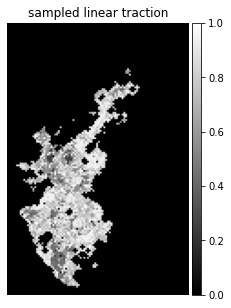

thres=0.3


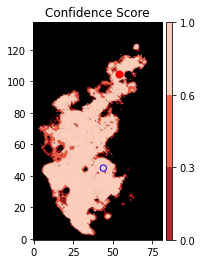

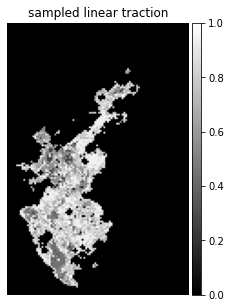

thres=0.6


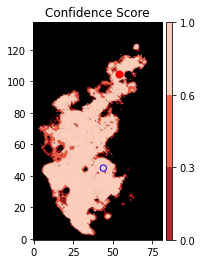

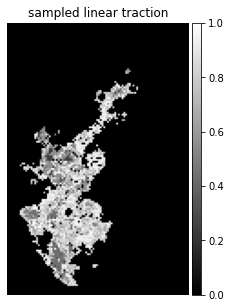

thres=0.9


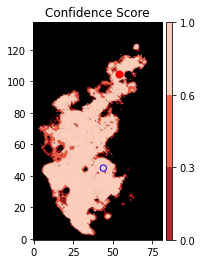

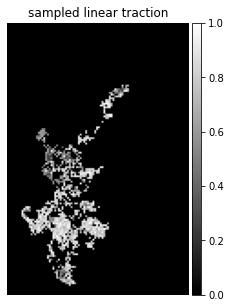

In [24]:
# for thres in [0, 0.3, 0.6, 0.9]:
#   print("thres={}".format(thres))
#   modified_pred_tdm_info = copy.deepcopy(pred_tdm_info)
#   # For places where we don't have access to ground truth, also mask away the same region in the predicted map.
#   gt_unknown = gt_tdm_info["unknown_colors_mask"]
#   modified_pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
#   modified_pred_tdm_info["unknown_colors_mask"][gt_unknown] = 1
#   # Adjust the PMF
#   modified_pred_tdm_info["lin_pmf_grid"][0,gt_unknown] = 100
#   modified_pred_tdm_info["lin_pmf_grid"][1:,gt_unknown] = 0
#   modified_pred_tdm_info["ang_pmf_grid"][0,gt_unknown] = 100
#   modified_pred_tdm_info["ang_pmf_grid"][1:,gt_unknown] = 0
#   # For places where ground truth is 0 traction, we mask away the predicted map as well
#   gt_no_traction_mask = gt_tdm_info["lin_pmf_grid"][0,:,:]==100
#   modified_pred_tdm_info["lin_pmf_grid"][0,gt_no_traction_mask]=100
#   modified_pred_tdm_info["lin_pmf_grid"][1:,gt_no_traction_mask]=0
#   modified_pred_tdm_info["ang_pmf_grid"][0,gt_no_traction_mask]=100
#   modified_pred_tdm_info["ang_pmf_grid"][1:,gt_no_traction_mask]=0

#   # Mask away the tractions where confidence score is very low
#   low_conf_mask = modified_pred_tdm_info["normalized_confidence"] < thres
#   modified_pred_tdm_info["lin_pmf_grid"][0,low_conf_mask]=100
#   modified_pred_tdm_info["lin_pmf_grid"][1:,low_conf_mask]=0
#   modified_pred_tdm_info["ang_pmf_grid"][0,low_conf_mask]=100
#   modified_pred_tdm_info["ang_pmf_grid"][1:,low_conf_mask]=0



#   fig, ax = plt.subplots()
#   img = ax.imshow(modified_pred_tdm_info['normalized_confidence'], origin='lower', vmin=0, vmax=1.0, cmap='gray', alpha=1.0)
#   ctr = ax.contourf(modified_pred_tdm_info['normalized_confidence'],
#                   #  levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
#                   levels=[0.0, 0.3, 0.6, 1.0], 
#                   #  cmap="YlOrRd_r",
#                   cmap="Reds_r",
#                   #  cmap="viridis",
#                   alpha=0.9, antialiased=True)
#   hm_x0 = copy.deepcopy(x0)
#   hm_xgoal = copy.deepcopy(xgoal)
#   hm_x0[0] = (hm_x0[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
#   hm_x0[1] = (hm_x0[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res
#   hm_xgoal[0] = (hm_xgoal[0] - gt_lin_tdm.xlimits[0])/gt_lin_tdm.res
#   hm_xgoal[1] = (hm_xgoal[1] - gt_lin_tdm.ylimits[0])/gt_lin_tdm.res

#   ax.scatter([hm_x0[0]], [hm_x0[1]], c='r', s=50)
#   c1 = plt.Circle(hm_xgoal, mppi_params['goal_tolerance'], color='b', fill=False, label="Goal", zorder=6)
#   ax.add_patch(c1)
#   # ax.scatter([xgoal[0]], [xgoal[1]], c='white', s=50, filled=False)
#   ax.set_title('Confidence Score')
#   divider = make_axes_locatable(ax)
#   cax = divider.append_axes("right", size="5%", pad=0.05)
#   # plt.colorbar(img, cax=cax)
#   plt.colorbar(ctr, cax=cax)
#   plt.show()


#   # Update the lin_tdm and ang_tdm of the predicted version

#   # Construct the MPPI planner + initialize the GPU variables
#   obstacle_map = None # 
#   unknown_map = np.zeros(semantic_grid.shape, dtype=np.int8) 
#   unknown_map[semantic_grid==-1] = 1
#   # obstacle_map[semantic_grid==-1] = 1

#   # Use the outlier detection threshold 
#   confidence_thres = 0.1
#   unknown_map[pred_tdm_info["normalized_confidence"] < confidence_thres] = 1
#   # obstacle_map[pred_tdm_info["normalized_confidence"] < confidence_thres] = 1

#   reset_tdm_from_info(gt_lin_tdm, gt_ang_tdm, gt_tdm_info, mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)
#   reset_tdm_from_info(pred_lin_tdm, pred_ang_tdm, modified_pred_tdm_info, mppi_params['alpha_dyn'], obstacle_map=obstacle_map, unknown_map=unknown_map)
#   mppi_planner.reset()
#   mppi_planner.setup(mppi_params, pred_lin_tdm, pred_ang_tdm)


#   # Firstly, sample traction from the GROUNDTRUTH!
#   traction_grid = sample_traction_grid(gt_lin_tdm, gt_ang_tdm)


#   traction_grid = sample_traction_grid(pred_lin_tdm, pred_ang_tdm)
#   lin = traction_grid.lin_traction
#   ang = traction_grid.ang_traction
#   fig, ax = plt.subplots(figsize=(5,5))
#   # lin = traction_grid.lin_traction
#   img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
#   ax.set_title('sampled linear traction')
#   ax.axis('off')
#   divider = make_axes_locatable(ax)
#   cax = divider.append_axes("right", size="5%", pad=0.05)
#   plt.colorbar(img, cax=cax)
#   plt.show()
